# Topic Modeling of Environmental News Coverage

**TL;DR:** This project models topics in environmental news using full-text articles from various news sources (e.g., NYTimes, Fox News). The code here presents only the topic modeling part.

This project aims to model topics in environment news covered by various sources over several years. My goal here is to explore topics using unsupervised learning techniques and to assess their performance in detecting subtopics. These techniques include (1) matrix decomposition/factorization: e.g., NMF (Non-negative Matrix Factorization), LDA (Latent Dirichlet Allocation), PCA (Pricinpal Component Analysis) and (2) clustering algorithms (e.g., KMeans). Regarding data sources, I obtained full-text articles from NYTimes and Fox News to compare their coverage with each other. NYTimes was seleted specifically for its extensively developed [API](https://developer.nytimes.com/docs/articlesearch-product/1/overview) and Fox News due to it being a good comparison point to NYTimes. Additionally, I used [NewsAPI](https://newsapi.org/) to get articles from a plethora of sources up to 1 month old ([free plan](https://newsapi.org/pricing)). Results of this project are displayed as an [interactive Tableau dashboard](https://public.tableau.com/profile/khoa.lam#!/vizhome/NYT_2/README) in 3 tabs: (1) evolution of environmental topics in NYTimes over 16 years, (2) comparison between NYTimes vs. Fox News, and (3) topics distribution in articles obtained by NewsAPI.

This project consists of three parts:
1. Getting URLs for environment-related articles (codes available [here](./url-codes/))
2. Downloading full-text articles from [URLs](../urls-data/) using [newspaper API](https://newspaper.readthedocs.io/en/latest/) and storing them on MongoDB on an AWS-EC2 instance.
3. Using NLP techniques to model topics
4. Integrating modeling data into Tableau for visualization and comparison

The code here focuses only on part (3) of the project:
1. Extracting full-text from MongoDB on AWS-EC2 instance
2. Using `sklearn` and `nltk` packages,
    1. Tokenizing sentences into words, vectorizing words into sparse matrix
    2. Factorizing document/word matrix into document/topic and topic/word matrix
3. Visualizing top words by coefficients for each topic
4. Performing sensitivity analysis by varying vectorizer's parameters

In [2]:
import pymongo
import pandas as pd
% pylab inline
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [1]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import SnowballStemmer, LancasterStemmer, ISRIStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE

In [264]:
# connect to MongoDB on AWS
client = pymongo.MongoClient('mongodb://18.206.205.173/environment')

db = client.environment
nyt = db.nytimes
newsapi = db.newsapi
fox = db.foxnews

In [6]:
# extract full text and store as pandas Series
def make_text(source):
    text = []
    for i in source.find():
        text.append(i['text'])
    return pd.Series(text)

def make_headline(source):
    headline = []
    for i in source.find():
        headline.append(i['title'])
    return pd.Series(headline)

def make_url(source):
    url = []
    for i in source.find():
        url.append(i['url'])
    return pd.Series(url)

def make_pubdate(source):
    url = []
    for i in source.find():
        url.append(i['publish_date'])
    return pd.Series(url)

In [266]:
fox_hl = make_headline(fox)
fox_t = make_text(fox)
fox_date = make_pubdate(fox)
fox_url = make_url(fox)

nyt_hl = make_headline(nyt)
nyt_t = make_text(nyt)
nyt_url = make_url(nyt)
nyt_date = make_pubdate(nyt)

newsapi_t = make_text(newsapi)
newsapi_url = make_url(newsapi)
newsapi_date = make_pubdate(newsapi)

In [33]:
# combine Fox News and NYTimes articles (to compare topics by source)
foxdf = pd.DataFrame()
foxdf['url'] = fox_url
foxdf['pub_date'] = fox_date
foxdf['text'] = fox_t
foxdf['source'] = 'Fox News'

nytdf = pd.DataFrame()
nytdf['url'] = nyt_url
nytdf['pub_date'] = nyt_date
nytdf['text'] = nyt_t
nytdf['source'] = 'New York Times'

env = foxdf.append(nytdf, ignore_index=True)
env['year'] = env['pub_date'].dt.year
env['month'] = env['pub_date'].dt.month

# subset of the articles limited by published date (to compare topics within the same time frame)
datelim = env.groupby('source')['pub_date'].min().max()
envsub = env[env['pub_date'] >= datelim]
envsub.reset_index(drop=True, inplace=True)

In [252]:
# punctuations and symbols
puncs = string.punctuation + '’\'[](){}⟨⟩:,،、‒–—―…...⋯᠁ฯ!,.‹›«»‐--?‘’“”''"";,,/⧸⁄·&*@\‱•^†‡°”=¡¿,,※×,,#№÷ºª,%‰,+−--±∓¶′‴§~,_,,|‖¦©-℗®℠™¤₳฿₵¢₡₢$₫₯֏₠€ƒ₣₲₴₭₺₾₼ℳ₥₦₧₱₰£元圆圓៛₽₹₨₪৳₸₮₩¥円⁂,❧,☞‽⸮◊⁀'

# stopwords
addstops = ['news', 'new', 'york', 'times', 'image', 'copyright', 'washington', 'post'] # NYTimes copyright text
swords = stopwords.words('english') + list(ENGLISH_STOP_WORDS) + addstops

pun = str.maketrans('', '', puncs)
dig = str.maketrans('', '', string.digits)
lem = WordNetLemmatizer()

def token(text):
    nopundig = text.translate(pun).translate(dig).lower() # remove punctuations and digits
    tokens = word_tokenize(nopundig) # tokenization (sentences into words)
    stops = [i for i in tokens if i not in swords] # remove stopwords
    lems = [lem.lemmatize(i) for i in stops] # lemmatization (group words into dictionary base form)
    return lems

Here, I combine and streamline (1) tokenization and vectorization, (2) topic modeling (i.e., matrix decomposition/factorization), and (3) visual assessment of model performance all within one function. 
Parameters (e.g., `max_df`, `min_df`, `ngram_range` of the vectorizer and `n_components` of the decomposition method) were varied to achieve best separation between topics. Top words indicative of each topic (ordered by decreasing coefficients) are displayed as a heatmap. The code here can be expanded to include more methods of vectorization (e.g., TF-IDF, CV `CountVectorizer`), decomposition (e.g., LDA, NMF, TSNE, PCA). Afterwards, PCA was used to project document/topic matrix into 2 dimensional space for visualization in Tableau.

In [12]:
def vec_tml(text, vec, tml, vec_max, vec_min, vec_ngram, ncomps, nwords):
    
    # choose your favorite matrix vectorizer
    if vec == 'tfidf':
        cv = TfidfVectorizer(tokenizer=token, max_df=vec_max, min_df=vec_min, ngram_range=vec_ngram)
    else: cv = CountVectorizer(tokenizer=token, max_df=vec_max, min_df=vec_min, ngram_range=vec_ngram)
    cnt = cv.fit_transform(pd.Series(text))
    
    # choose your favorite matrix decomp tool
    if tml == 'nmf':
        nmf = NMF(n_components=ncomps)
    else: nmf = LatentDirichletAllocation(n_components=ncomps, max_iter=5,
                                          learning_method='online', learning_offset=50)
    tops = nmf.fit_transform(cnt)
    
    # top nwords words (by coefficient) for each topic using heatmap
    df = pd.DataFrame(nmf.components_, columns=cv.vocabulary_.keys())
    words = df.apply(lambda i: list(i.nlargest(nwords).index), axis=1, result_type='expand')
    comps = df.apply(lambda i: list(i.nlargest(nwords)), axis=1, result_type='expand')
    
    _, ax = plt.subplots(figsize=(nwords * 2, ncomps / 2));
    sns.heatmap(comps, annot=words, fmt='', ax=ax, cmap='Blues',
                yticklabels=['topic {}'.format(i) for i in range(ncomps)],
                xticklabels=['word {}'.format(i) for i in range (nwords)]);
    
    return cv, cnt, nmf, tops

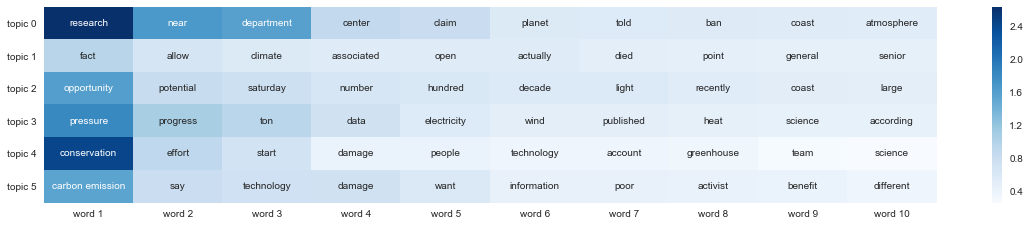

In [291]:
# subset of articles (of NYTimes and Fox News)
cv, words, nmf, topics = vec_tml(text=envsub['text'], vec='tfidf', tml='nmf',
                                 vec_max=0.5, vec_min=0.05, vec_ngram=(1, 2), ncomps=6, nwords=10);

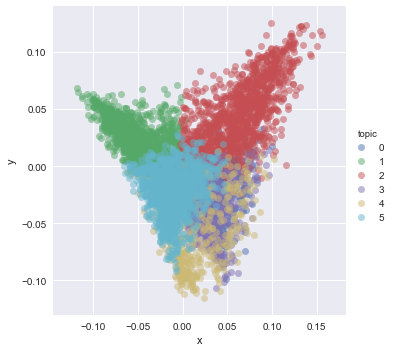

In [292]:
# project topic matrix into 2 dimensional space
pca = PCA(n_components=2)
coords = pca.fit_transform(topics)

clus = pd.DataFrame(coords)
hard = pd.DataFrame(pd.DataFrame(np.argsort(-topics))[0]).rename(columns={0: 'topic'})
sns.lmplot('x', 'y', data=clus.join(hard).rename(columns={0: 'x', 1: 'y'}),
           hue='topic', fit_reg=False, scatter_kws={'alpha': 0.5});

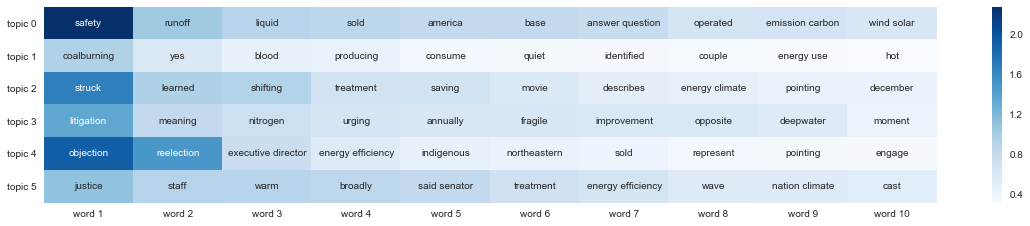

In [301]:
# only NYTimes articles
cv, words, nmf, topics = vec_tml(text=nytdf['text'], vec='tfidf', tml='nmf',
                                 vec_max=0.5, vec_min=150, vec_ngram=(1, 2), ncomps=6, nwords=10);

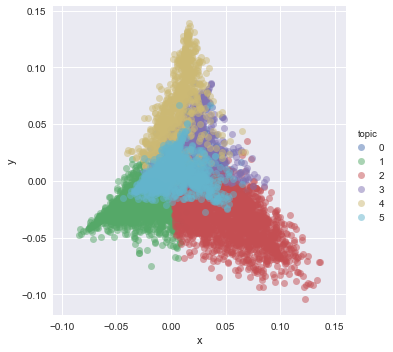

In [302]:
# project topic matrix into 2 dimensional space
pca = PCA(n_components=2)
coords = pca.fit_transform(topics)

clus = pd.DataFrame(coords)
hard = pd.DataFrame(pd.DataFrame(np.argsort(-topics))[0]).rename(columns={0: 'topic'})
sns.lmplot('x', 'y', data=clus.join(hard).rename(columns={0: 'x', 1: 'y'}),
           hue='topic', fit_reg=False, scatter_kws={'alpha': 0.5});

It is difficult to assess the model by only looking at the topic words and PCA graphs. Therefore, I exported these dataframes into CSV and used Tableau to view information of the articles (e.g., headlines) in each topic space. Using only NYTimes articles as the model input gives me the best topics:
1. Renewable energy
2. Disasters & Others (catch-all)
3. Climate change
4. Government
5. Nuclear power
6. Environmental regulation

Additionally, topic distribution over time ([tab "New York Times" of dashboard](https://public.tableau.com/profile/khoa.lam#!/vizhome/NYT_2/README)) further supports this model validity as increase in number of articles in a topic (e.g., nuclear power) coincides with an event related to that topic (e.g., Fukushima Nuclear Accident).

Once topics are determined, full-text articles of other dataframes (NYTimes/Fox News and NewsAPI) are vectorized into document/text matrices and transformed into document/topic matrices using the same CV (`CountVectorizer`) and NMF used to model topics of the NYTimes.

In [269]:
apidf = pd.DataFrame()
apidf['url'] = newsapi_url
apidf['pub_date'] = newsapi_date
apidf['text'] = newsapi_t

In [303]:
# vectorize text and transform document/text matrix into document/topic matrix
api = cv.transform(apidf['text'])
nytfox = cv.transform(envsub['text'])

topapi = nmf.transform(api)
topnytfox = nmf.transform(nytfox)

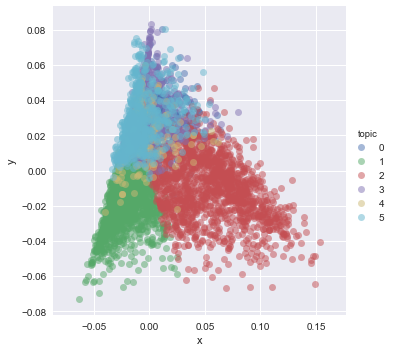

In [317]:
# topic space for NYTimes/Fox News subset
pca = PCA(n_components=2)
coords = pca.fit_transform(topnytfox)

clus = pd.DataFrame(coords)
hard = pd.DataFrame(pd.DataFrame(np.argsort(-topnytfox))[0]).rename(columns={0: 'topic'})
sns.lmplot('x', 'y', data=clus.join(hard).rename(columns={0: 'x', 1: 'y'}),
           hue='topic', fit_reg=False, scatter_kws={'alpha': 0.5});

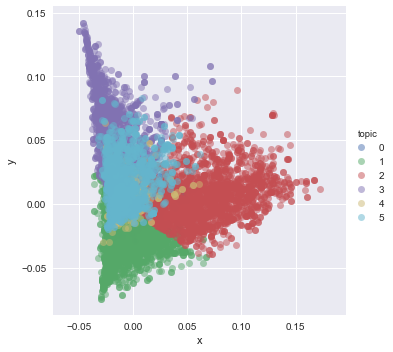

In [319]:
# topic space for NewsAPI
pca = PCA(n_components=2)
coords = pca.fit_transform(topapi)

clus = pd.DataFrame(coords)
hard = pd.DataFrame(pd.DataFrame(np.argsort(-topapi))[0]).rename(columns={0: 'topic'})
sns.lmplot('x', 'y', data=clus.join(hard).rename(columns={0: 'x', 1: 'y'}),
           hue='topic', fit_reg=False, scatter_kws={'alpha': 0.5});

In [645]:
# different tool to visualize topic space (TSNE)
tsne = TSNE()
samdf = pd.DataFrame(topapi)
sam = np.array(samdf)
xy = tsne.fit_transform(sam)

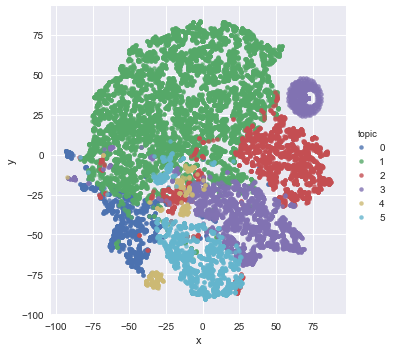

In [646]:
xydf = samdf.join(hard).reset_index(drop=True).join(pd.DataFrame(xy).rename(columns={0: 'x', 1: 'y'}))

sns.lmplot('x', 'y', data=xydf,
           hue='topic', fit_reg=False, scatter_kws={'s': 20});

I attempted to use clustering methods (e.g., KMeans, Agglomerative Clustering, Mean Shift) to analyze the NewsAPI corpus. However, the topics modeled by these methods are not as definitive as the NMF topics. The code here shows an example: Spectral Clustering.

In [497]:
sc = SpectralClustering(n_clusters=10)
clussc = sc.fit_predict(topapi)

top = pd.DataFrame(clussc).rename(columns={0: 'cluster'})

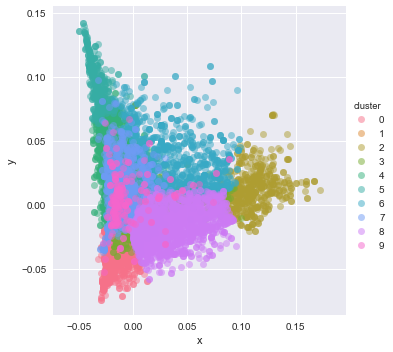

In [499]:
sns.lmplot('x', 'y', data=clus.join(top).rename(columns={0: 'x', 1: 'y'}),
           hue='cluster', fit_reg=False, scatter_kws={'alpha': 0.5});

In [500]:
# NMF topics in each cluster
clus.join(top).join(hard).groupby('cluster')['topic'].agg({lambda i: set(i), size})

,size,<lambda>
cluster,,
0,2697,{1}
1,6929,"{0, 1, 2, 3, 4, 5}"
2,523,{2}
3,1436,"{0, 1, 2, 3, 5}"
4,2660,"{0, 1, 2, 3, 4, 5}"
5,385,{3}
6,915,"{2, 3, 4, 5}"
7,1408,"{1, 3, 5}"
8,2360,"{1, 2, 4, 5}"
